In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#import seaborn as sn

from sklearn.decomposition import PCA #features extraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #data standardization

%matplotlib inline

In [2]:
DATA_PATH_MALWARE = "../csv/malware"
DATA_PATH_GOODWARE = "../csv/goodware"
DATASET_PATH = "../csv"
col_names = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp',
             'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
             'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
             'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
             'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
             'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
             'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
             'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
             'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
             'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
             'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
             'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
             'Fwd Header Length_1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
             'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
             'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
             'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
             'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

# COSTRUZIONE DATASET
* avendo il dataset scomposto in molteplici *csv* vado a unirli in uno singolo, almeno per un primo momento, distinguendo i files contenti traffico benevolo e malevolo;
* rinomino i campi secondo le seguenti caratteristiche:
    * parole separate da spazio anzichè da '_';
    * prima lettera di ogni parola sarà maiuscola.
* a ogni record gli accosto un codice che identifica univocamnete il Sample che ha la seguete struttura: *{G,M}\_N*, dove:
    * **G** ed **M** indicano rispettivamente goodware e malware;
    * **N** indica il numero del sample preso in considerazione

In [38]:
def __change_name_and_order(data):
    new_names = list()
    #data = pd.read_csv(csv_path)

    for col in data.columns:
        new_name = col.split('_')
        new_names.append(" ".join(new_name).title()) #funzione title trasforma la prima lettera di ogni parola in maiuscolo (capitalizza)
        #print(new_name)
    data.columns = new_names

    #riordinamento delle features
    data = data.loc[:, ["Src Ip", "Src Port", "Dst Ip", "Dst Port", "Protocol", "Timestamp", "Flow Duration", "Tot Fwd Pkts",
           "Tot Bwd Pkts", "Totlen Fwd Pkts", "Totlen Bwd Pkts", "Fwd Pkt Len Max", "Fwd Pkt Len Min", "Fwd Pkt Len Mean",
           "Fwd Pkt Len Std", "Bwd Pkt Len Max", "Bwd Pkt Len Min", "Bwd Pkt Len Mean", "Bwd Pkt Len Std", "Flow Byts S",
           "Flow Pkts S", "Flow Iat Mean", "Flow Iat Std", "Flow Iat Max", "Flow Iat Min", "Fwd Iat Tot", "Fwd Iat Mean",
           "Fwd Iat Std", "Fwd Iat Max", "Fwd Iat Min", "Bwd Iat Tot", "Bwd Iat Mean", "Bwd Iat Std", "Bwd Iat Max",
           "Bwd Iat Min","Fwd Psh Flags", "Bwd Psh Flags", "Fwd Urg Flags", "Bwd Urg Flags",
           "Fwd Header Len", "Bwd Header Len", "Fwd Pkts S", "Bwd Pkts S", "Pkt Len Min", "Pkt Len Max", "Pkt Len Mean",
           "Pkt Len Std", "Pkt Len Var", "Fin Flag Cnt", "Syn Flag Cnt", "Rst Flag Cnt", "Psh Flag Cnt", "Ack Flag Cnt",
           "Urg Flag Cnt", "Cwe Flag Count", "Ece Flag Cnt", "Down Up Ratio", "Pkt Size Avg", "Fwd Seg Size Avg",
           "Bwd Seg Size Avg", "Fwd Header Len", "Fwd Byts B Avg", "Fwd Pkts B Avg", "Fwd Blk Rate Avg", "Bwd Byts B Avg",
           "Bwd Pkts B Avg", "Bwd Blk Rate Avg", "Subflow Fwd Pkts", "Subflow Fwd Byts", "Subflow Bwd Pkts",
           "Subflow Bwd Byts", "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Act Data Pkts", "Fwd Seg Size Min",
           "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min"]]

    return data

def csv_merging(dest_df, files_path):
    id_num = 1

    for csv_file in os.listdir(files_path):
        if not (csv_file == ".DS_Store" or "Monday-WorkingHours" in csv_file):
            print(csv_file)
            data = pd.read_csv(f"{files_path}/{csv_file}", encoding='utf-8', sep=',', engine='python')

            data = __change_name_and_order(data)

            if "malware" in files_path:
                data["Sample ID"] = f"M_{id_num}"
            else:
                data["Sample ID"] = f"G_{id_num}"
            id_num += 1

            dest_df = pd.concat([dest_df, data])

    print('\n')

    return dest_df

In [ ]:
csv_merging(pd.DataFrame(), DATA_PATH_MALWARE).to_csv(f"{DATASET_PATH}/malware.csv", index=False)
csv_merging(pd.DataFrame(), DATA_PATH_GOODWARE).to_csv(f"{DATASET_PATH}/goodware.csv", index=False)

Per problemi lo script mostrato sopra per *Monday-WorkingHours.csv* non funzione quindi procedo a una procedura ad hoc.

In [40]:
goodware = pd.read_csv(f"{DATASET_PATH}/goodware.csv", low_memory=False)
monday = pd.read_csv(f"{DATA_PATH_GOODWARE}/Monday-WorkingHours.csv", low_memory=False)

monday["Sample ID"] = "G_51"
monday.columns = goodware.columns

pd.concat([goodware, monday]).to_csv(f"{DATASET_PATH}/goodware.csv", index=False)

del goodware, monday

* eseguo labelling dei dati (MALWARE/BENIGN)

In [41]:
for csv in os.listdir(DATASET_PATH):
    if csv.endswith(".csv"):
        df = pd.read_csv(f"{DATASET_PATH}/{csv}", low_memory=False)

        if "malware" in csv:
            df['Label'] = "MALWARE"
        else:
            df['Label'] = "BENIGN"

        df.to_csv(f"{DATASET_PATH}/{csv}", index=False)

* unisco i due dataset creati al primo punto, in un singolo dataset

# NORMALIZZAZIONE DATASET
* accstare porta e IP sorgente (analogamete per la destinarione);
* eliminare punto da stringa che indica l'IP;
* cambiare tipi delle features, dove necessario:

Ultimi due passi sono necessari perchè algoritmi di ML accettano solo valori numerici.

In [47]:
def normalize_ip(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)

    data.iloc[:, 0] = data.iloc[:, 0].map(lambda ip : __string_to_integer_ip(ip))
    data.iloc[:, 2] = data.iloc[:, 2].map(lambda ip : __string_to_integer_ip(ip))

    data.to_csv(csv_path, index=False)

def __string_to_integer_ip(ip):
    if not isinstance(ip, int):
        splitted_ip = ip.split('.')

        return "".join(splitted_ip)
    return ip

def change_features_type(csv_path, features_types):
    data = pd.read_csv(csv_path, low_memory=False)

    for i in range(data.shape[1]):
        data.iloc[:, i].astype(features_types[i])

    data.to_csv(csv_path, index=False)

Converto il formato stringa dell'indirizzo IP (aaa.bbb.ccc.ddd) in un formato comprensibile all'algoritmo di machine learning, cioè un intero nel seguente formato **aaabbbcccddd**.

In [48]:
normalize_ip(f"{DATASET_PATH}/malware.csv")
normalize_ip(f"{DATASET_PATH}/goodware.csv")

Unione dataset goodware e malware in un unico file in formato csv

In [49]:
df_malware = pd.read_csv(f"{DATASET_PATH}/malware.csv", low_memory=False)
df_goodware = pd.read_csv(f"{DATASET_PATH}/goodware.csv", low_memory=False)

pd.concat([df_malware, df_goodware]).to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

del df_malware, df_goodware

In [5]:
dataset = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)

Convertire i timestamp in formato numerico

In [19]:
unix_ts = pd.to_datetime(dataset['Timestamp']).view('int64')

dataset['Timestamp'] = unix_ts

del unix_ts

Creare flowID (IPscr, portScr, IDdst, portDst, Protocollo)

In [21]:
dataset['FlowID'] = dataset['Src Ip'].map(str) + "_"+ dataset['Src Port'].map(str) + "_" + dataset['Dst Ip'].map(str) + "_"  + dataset['Dst Port'].map(str) + "_" + dataset['Protocol'].map(str)

dataset.set_index('FlowID').to_csv(f"{DATASET_PATH}/dataset.csv")

Convertire le etichette in formato numerico: (MALWARE -> 1.0 e GOODWARE -> 0.0)

In [6]:
dataset['Label'].replace(["MALWARE", "BENIGN"], [1.0, 0.0], inplace=True)

dataset.to_csv(f"{DATASET_PATH}/ML.csv", index=False)

del dataset

# FEATURES EXTRACTION

In [3]:
dataset = pd.read_csv(f"{DATASET_PATH}/ML.csv", low_memory=False)

In linea generale il processo di feature extraction consiste nel scegliere le migliori features riducendo così la dimensionalità del dataset per fare ciò va do a sfruttare la **PCA (Principal Componenet Analyis)** fornita da *scikit-learn*.

Prima di effettuare la features extraction sopra descritta necessito di effettuare un processo di "bonifica" del dataset.

In [4]:
dataset[dataset.isin(['78,125'])].stack()

1642652  Flow Pkts S    78,125
dtype: object

*Flow Pkts S* in linea generale contiene valori *double*, ma nel caso sopra citato contiene una stringa; per questo motivo vado a convertirlo in double.

In [5]:
dataset.at[1642652, 'Flow Pkts S'] = 78.125

dataset.loc[1642652, 'Flow Pkts S']

78.125

Controllo se sono presenti valori *NaN* e *Inf*

In [6]:
#conteggio valori NaN
dataset.isnull().sum().sum()

89

In [7]:
#conteggio valori Inf
dataset[dataset == np.inf].count()

26FlowID     0
Src Ip       0
Src Port     0
Dst Ip       0
Dst Port     0
            ..
Idle Std     0
Idle Max     0
Idle Min     0
Sample ID    0
Label        0
Length: 86, dtype: int64

Visto la presenza di valori NaN e Inf, per semplicità vado a cancellarli.

In [8]:
print(f"Before NaN & Inf deletion: {dataset.shape}")

with pd.option_context('mode.use_inf_as_na', True):
  dataset.dropna(inplace=True)

print(f"After NaN & Inf deletion: {dataset.shape}")

Before NaN & Inf deletion: (1687394, 86)
After NaN & Inf deletion: (1686932, 86)


Prima di effettuare la PCA necessito di andare a standardizzare i dati

In [87]:
def feature_extraction(data, n_components, norm=False):
    if norm:
        scalar = StandardScaler()
        scalar.fit(data)
        data = scalar.transform(data)

    pca = PCA(n_components)

    pca.fit(data)

    #X_train = pca.transform(X_train)
    #X_test = pca.transform(X_test)

    return pca

In [ ]:
X, y = dataset.loc[:, 'Src Ip' : 'Idle Min'], dataset.loc[:, 'Label']

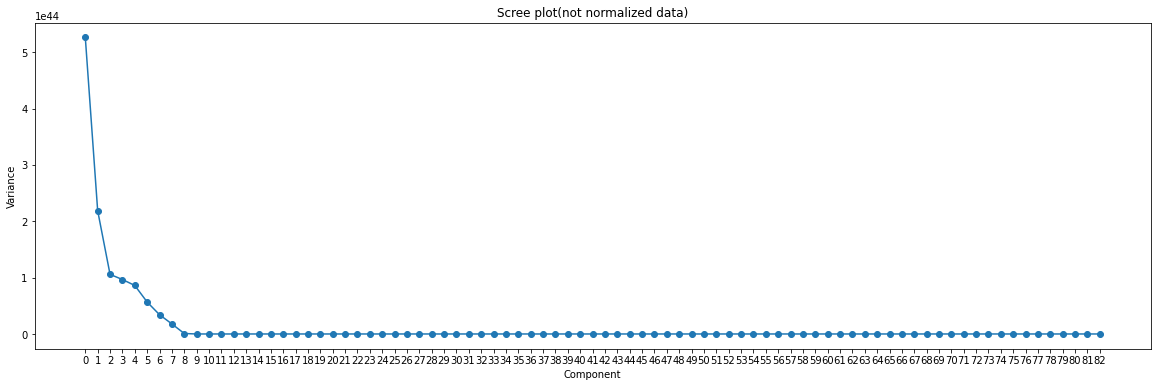

In [94]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, train_size=.8)

#X_train = scalar.transform(X_train)
#X_test = scalar.transform(X_test)
pca = feature_extraction(X, X.shape[1], False)

plt.figure(figsize=(20, 6))
plt.plot(range(pca.n_components_), pca.explained_variance_)
plt.scatter(range(pca.n_components_), pca.explained_variance_)
plt.title("Scree plot(not normalized data)")
plt.xlabel("Component")
plt.xticks(range(pca.n_components_), range(pca.n_components_))
plt.ylabel("Variance")
plt.show()

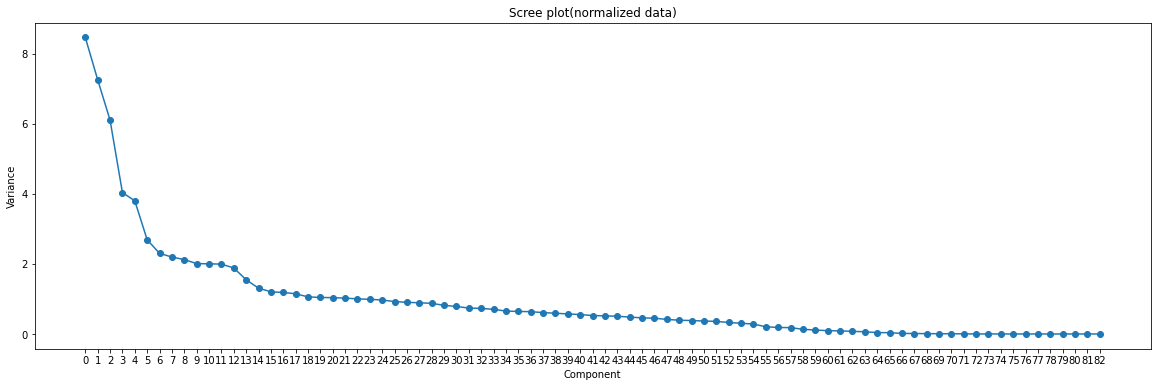

In [96]:
pca_norm = feature_extraction(X, X.shape[1], True)

plt.figure(figsize=(20, 6))
plt.plot(range(pca_norm.n_components_), pca_norm.explained_variance_)
plt.scatter(range(pca_norm.n_components_), pca_norm.explained_variance_)
plt.title("Scree plot(normalized data)")
plt.xlabel("Component")
plt.xticks(range(pca_norm.n_components_), range(pca_norm.n_components_))
plt.ylabel("Variance")
plt.show()

Dai grafici presentati del caso di dati non normalizzati si andrebbero a estrarre **6/7 features**, oppure nel caso di dati normalizzati ado a estrarre **dalle 13 alle 57 features**.

Per trovare con maggior precisione il numero di features attraverso la **regola di Kaiser** in cui si tengono solo le componenti che hanno un valore della varianza(autovalori) non sia **inferiore a 1 oppure a 0.7**. In letteratura la primo valore risulta troppo alto.

In [109]:
print("Threshold 1")
print(f"Regola di Kaiser su dati non normalizzati: {len(pca.explained_variance_[pca.explained_variance_ > 1])} features")
print(f"Regola di Kaiser su dati normalizzati: {len(pca_norm.explained_variance_[pca_norm.explained_variance_ > 1])} features")

Threshold 1
Regola di Kaiser su dati non normalizzati: 83 features
Regola di Kaiser su dati normalizzati: 23 features


In [110]:
print("Threshold 0.7")
print(f"Regola di Kaiser su dati non normalizzati: {len(pca.explained_variance_[pca.explained_variance_ > .7])} features")
print(f"Regola di Kaiser su dati normalizzati: {len(pca_norm.explained_variance_[pca_norm.explained_variance_ > .7])} features")

Threshold 0.7
Regola di Kaiser su dati non normalizzati: 83 features
Regola di Kaiser su dati normalizzati: 34 features


In linea di massima da come si è visto dai risultati sopra la regola di Kaiser funziona solo su **dati normalizzati**, ottenedo un totale di 23 o 34 featiures rispettivamete nel caso in cui il threshold sia 1 o 0.7. Così facendo si riduce del **72%**(23 features) o del **59%**(34 features).

I risultati descritti sopra soddisfano la condizione descritta dai grafici ottenuta analizzando l'andamento dei grafici vedendo dove avviene la suddivisone tra autovalori "grandi" e "piccoli" che viene contrassegnato da un "gomito".

# BILANCIAMENTO DATASET

Prima di tutto voglio andare a vedere come le due classi sono distribuite all'interno del dataset

In [13]:
labels, counts = np.unique(dataset['Label'], return_counts=True)

print(labels)
print(counts)

[0. 1.]
[1592331   94601]


Si vede che la classe *BENIGN*, contrassegnato con lo 0, è quella maggiormente presente con un totale di 1592331 records contro i 94601 dei recods malevoli

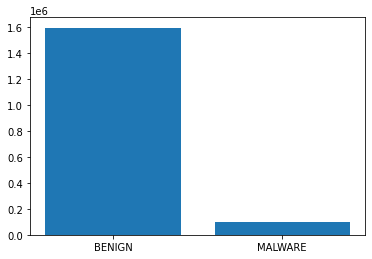

In [15]:
labels = np.where(labels == 0., "BENIGN", "MALWARE")

plt.bar(labels, counts)
plt.show()

Le tecniche che vorrei utilizzare per bilanciare il dataset sono principalmente 2: sfruttare la **focal loss** o la **SMOTE** (Synthetic Minority Oversampling Technique).


# ADDESTRAMENTO DEL MODELLO

# VALUTAZIONE DEL MODELLO